# Terralyte Model Benchmarking Suite

Relative + Absolute Benchmark Notebook  
Compares `verifier1.pt` vs `verifier2.pt`, and evaluates against real ground truth.


In [1]:
# IMPORTS

import os
import csv
import json
import math
import subprocess
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    mean_absolute_error
)

In [2]:
# CONFIGURATION

PY = "/usr/local/bin/python3"  

MODEL1 = "verifier1.pt"
MODEL2 = "verifier2.pt"

# CSVs
RELATIVE_CSV = "rel_benchmark.csv"      # sample_id,lat,lon
ABSOLUTE_CSV = "abs_benchmark.csv"       # sample_id,lat,lon,has_solar,panel_count

print("Using Python:", PY)

Using Python: /usr/local/bin/python3


In [3]:
# HELPERS 
def run_tile_download(lat, lon, zoom=18, radius=1):
    """Runs imagenRunner.py and returns tile PNG path."""
    p = subprocess.run(
        [PY, "imagenRunner.py", str(lat), str(lon), str(zoom), str(radius), "esri", "--crop"],
        capture_output=True,
        text=True
    )
    if p.returncode != 0:
        raise RuntimeError(p.stderr)
    return p.stdout.strip().split("\n")[-1]


def run_model(image_path, model_path):
    """Runs YOLO model via run_model.py and returns JSON."""
    p = subprocess.run(
        [PY, "run_model.py", image_path, model_path],
        capture_output=True,
        text=True
    )
    if p.returncode != 0:
        raise RuntimeError(p.stderr)
    return json.loads(p.stdout.strip())

In [4]:
# RELATIVE BENCHMARKING

def relative_benchmark(csv_path):
    ids, m1_labels, m2_labels = [], [], []
    m1_counts, m2_counts = [], []

    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)

        for r in reader:
            sid = r["sample_id"]
            lat, lon = float(r["lat"]), float(r["lon"])

            print(f"→ {sid} ({lat}, {lon})")
            img = run_tile_download(lat, lon)

            r1 = run_model(img, MODEL1)
            r2 = run_model(img, MODEL2)

            ids.append(sid)
            m1_labels.append(1 if r1["has_solar"] else 0)
            m2_labels.append(1 if r2["has_solar"] else 0)

            m1_counts.append(r1["panel_count_est"])
            m2_counts.append(r2["panel_count_est"])

    return {
        "ids": ids,
        "m1_labels": m1_labels,
        "m2_labels": m2_labels,
        "m1_counts": m1_counts,
        "m2_counts": m2_counts,
    }

# RUN RELATIVE BENCHMARK

rel = relative_benchmark(RELATIVE_CSV)
print("\nRelative Benchmark Complete!")

→ BLR_001 (12.839524, 77.677248)
→ BLR_002 (12.846912, 77.667101)
→ BLR_003 (12.84925, 77.684993)
→ BLR_004 (12.851477, 77.696351)
→ BLR_005 (12.860191, 77.699812)
→ BLR_006 (12.865342, 77.708142)
→ BLR_007 (12.872991, 77.712915)
→ BLR_008 (12.877433, 77.721309)
→ BLR_009 (12.882881, 77.729422)
→ BLR_010 (12.889214, 77.738652)
→ BLR_011 (12.971619, 77.594634)
→ BLR_012 (12.974112, 77.605148)
→ BLR_013 (12.978477, 77.614591)
→ BLR_014 (12.982301, 77.625445)
→ BLR_015 (12.986937, 77.636892)
→ BLR_016 (12.990812, 77.643821)
→ BLR_017 (12.993512, 77.652111)
→ BLR_018 (12.997411, 77.66232)
→ BLR_019 (13.002774, 77.672141)
→ BLR_020 (13.007942, 77.682115)
→ BLR_021 (12.934937, 77.609321)
→ BLR_022 (12.938422, 77.620117)
→ BLR_023 (12.942812, 77.628933)
→ BLR_024 (12.948744, 77.636221)
→ BLR_025 (12.953122, 77.646111)
→ BLR_026 (12.958811, 77.657444)
→ BLR_027 (12.963552, 77.666932)
→ BLR_028 (12.968932, 77.675229)
→ BLR_029 (12.973551, 77.683994)
→ BLR_030 (12.978331, 77.692551)
→ BLR_031 (1

In [5]:
# RELATIVE METRICS

def relative_metrics(pred1, pred2):
    acc = accuracy_score(pred1, pred2)
    prec = precision_score(pred1, pred2)
    rec = recall_score(pred1, pred2)
    f1 = f1_score(pred1, pred2)
    return acc, prec, rec, f1

rel_metric = relative_metrics(rel["m1_labels"], rel["m2_labels"])

print("Relative Model2 vs Model1:")
print("Accuracy :", rel_metric[0])
print("Precision:", rel_metric[1])
print("Recall   :", rel_metric[2])
print("F1 Score :", rel_metric[3])

Relative Model2 vs Model1:
Accuracy : 0.54
Precision: 0.4838709677419355
Recall   : 0.6818181818181818
F1 Score : 0.5660377358490566


In [6]:
# ABSOLUTE BENCHMARKING

def absolute_benchmark(csv_path):
    gt_labels, gt_counts = [], []
    m1_labels, m1_counts = [], []
    m2_labels, m2_counts = [], []

    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)

        for r in reader:
            sid = r["sample_id"]
            lat = float(r["lat"])
            lon = float(r["lon"])
            gt_has = int(r["has_solar"])
            gt_cnt = int(r["panel_count"])

            print(f"→ {sid} ({lat}, {lon})")

            img = run_tile_download(lat, lon)

            r1 = run_model(img, MODEL1)
            r2 = run_model(img, MODEL2)

            gt_labels.append(gt_has)
            gt_counts.append(gt_cnt)

            m1_labels.append(1 if r1["has_solar"] else 0)
            m1_counts.append(r1["panel_count_est"])

            m2_labels.append(1 if r2["has_solar"] else 0)
            m2_counts.append(r2["panel_count_est"])

    return {
        "gt_labels": gt_labels,
        "gt_counts": gt_counts,
        "m1_labels": m1_labels,
        "m1_counts": m1_counts,
        "m2_labels": m2_labels,
        "m2_counts": m2_counts,
    }

absb = absolute_benchmark(ABSOLUTE_CSV)
print("\nAbsolute Benchmark Complete!")

→ BLR_001 (12.9716, 77.5946)
→ BLR_002 (12.9352, 77.6245)
→ BLR_003 (12.9862, 77.6051)
→ BLR_004 (12.9983, 77.5924)
→ BLR_005 (12.9121, 77.6328)
→ BLR_006 (12.9511, 77.5809)
→ BLR_007 (12.9278, 77.6762)
→ BLR_008 (12.9357, 77.6912)
→ BLR_009 (12.9443, 77.6102)
→ BLR_010 (12.9664, 77.6417)
→ BLR_011 (12.9195, 77.5341)
→ BLR_012 (12.9721, 77.5435)
→ BLR_013 (12.9836, 77.5512)
→ BLR_014 (12.9611, 77.5662)
→ BLR_015 (12.995, 77.6201)
→ BLR_016 (12.9827, 77.6655)
→ BLR_017 (12.9591, 77.6733)
→ BLR_018 (12.9478, 77.6844)
→ BLR_019 (12.9332, 77.6899)
→ BLR_020 (12.9248, 77.6128)
→ BLR_021 (12.9148, 77.5943)
→ BLR_022 (12.9023, 77.5928)
→ BLR_023 (12.9188, 77.582)
→ BLR_024 (12.9225, 77.5692)
→ BLR_025 (12.9321, 77.5569)
→ BLR_026 (12.9449, 77.551)
→ BLR_027 (12.9588, 77.5489)
→ BLR_028 (12.976, 77.5601)
→ BLR_029 (12.9892, 77.5715)
→ BLR_030 (12.9981, 77.5827)
→ BLR_031 (12.8955, 77.5951)
→ BLR_032 (12.8819, 77.612)
→ BLR_033 (12.8994, 77.6282)
→ BLR_034 (12.9066, 77.6439)
→ BLR_035 (12.9173,

In [7]:
# ABSOLUTE METRICS

def compute_abs(gt, pred, gt_cnt, pred_cnt):
    acc = accuracy_score(gt, pred)
    prec = precision_score(gt, pred, zero_division=0)
    rec = recall_score(gt, pred, zero_division=0)
    f1 = f1_score(gt, pred, zero_division=0)

    mae = mean_absolute_error(gt_cnt, pred_cnt)
    rmse = math.sqrt(sum((a - b)**2 for a, b in zip(gt_cnt, pred_cnt)) / len(gt_cnt))

    return acc, prec, rec, f1, mae, rmse


m1_abs = compute_abs(absb["gt_labels"], absb["m1_labels"], absb["gt_counts"], absb["m1_counts"])
m2_abs = compute_abs(absb["gt_labels"], absb["m2_labels"], absb["gt_counts"], absb["m2_counts"])

print("Model 1 Absolute:", m1_abs)
print("Model 2 Absolute:", m2_abs)

Model 1 Absolute: (0.48, 0.5882352941176471, 0.3448275862068966, 0.43478260869565216, 9.54, 13.309395177843356)
Model 2 Absolute: (0.58, 0.6666666666666666, 0.5517241379310345, 0.6037735849056604, 9.26, 12.886426967938009)


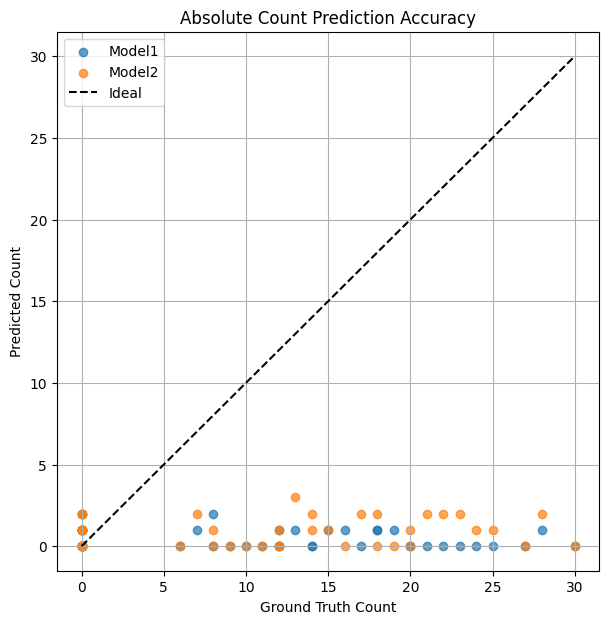

In [8]:
# PLOT

plt.figure(figsize=(7,7))
plt.scatter(absb["gt_counts"], absb["m1_counts"], label="Model1", alpha=0.7)
plt.scatter(absb["gt_counts"], absb["m2_counts"], label="Model2", alpha=0.7)
plt.plot([0, max(absb["gt_counts"])], [0, max(absb["gt_counts"])], 'k--', label="Ideal")

plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.legend()
plt.title("Absolute Count Prediction Accuracy")
plt.grid(True)
plt.show()